# 1. import libraries

In [1]:
import warnings
import numpy as np
import pandas as pd
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report

In [3]:
warnings.filterwarnings("ignore")
%matplotlib inline
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize'] = 15,5

---
# 2. import dataset

In [4]:
train = pd.read_csv('model.csv')
train.shape

(522, 6)

In [5]:
test = pd.read_csv('master.csv')
test = test[['DebtToIncome_bin', 'Interest_bin', 'NewCreditCustomer', 'Education', 'LoanDuration_bin', 'Y']]
test.shape

(179235, 6)

---
# 3. model

In [6]:
y = train['Y']
x = train.drop('Y', axis=1)
model = GradientBoostingClassifier(loss='deviance', max_depth=5, max_features='sqrt', 
                                   min_samples_leaf=100, n_estimators=200, random_state = 42)
model.fit(x, y)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=100, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [7]:
y = test['Y']
x = test.drop('Y', axis=1)
pred_values = model.predict_proba(x)

---
# 4. AUROC, Gini and KS

In [8]:
pred_values = pd.DataFrame(pred_values)[1]
print('AUROC:',np.round(roc_auc_score(y, pred_values), 3))

AUROC: 0.674


In [9]:
auroc = roc_auc_score(y, pred_values)
gini = 2 * auroc - 1
print('Gini:',np.round(gini, 3))

Gini: 0.349


In [10]:
train_dict = {'actuals':y, 'predicted':pred_values}
train_calc = pd.DataFrame(train_dict)

train_calc['1-actuals'] = 1-train_calc['actuals']
train_calc['1-predicted'] = 1-train_calc['predicted']
train_calc['bucket'] = pd.qcut(train_calc['1-predicted'], 10, duplicates='drop')

kstable = train_calc.groupby('bucket', as_index = False)[['1-actuals','actuals']].sum()
kstable['event_rate'] = (kstable['actuals'] / kstable['actuals'].sum()).cumsum()
kstable['non_event_rate'] = (kstable['1-actuals'] / kstable['1-actuals'].sum()).cumsum()
kstable['KS'] = (kstable['event_rate'] - kstable['non_event_rate']).abs()
print('KS:',np.round(kstable['KS'].max(), 3))

KS: 0.312


---
# 5. Cut-off

In [11]:
train_dict = {'actuals':y, 'predicted':pred_values}
test_calc = pd.DataFrame(train_dict)

max f:  0.45


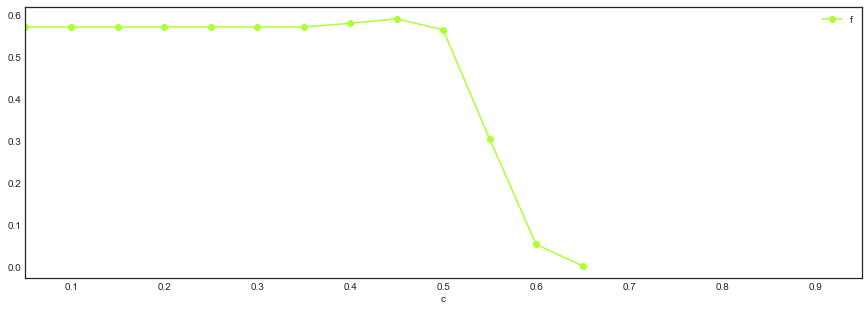

In [12]:
c = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95]
f = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95]
i = 0
for j in c:
    def flag(x):
        if x > j: return 1
        else: return 0
    test_calc['flag'] = test_calc['predicted'].apply(flag)
    df_table = confusion_matrix(test_calc['actuals'],test_calc['flag'])
    p = df_table[1,1] / (df_table[1,1] + df_table[0,1])
    r = df_table[1,1] / (df_table[1,1] + df_table[1,0])
    f[i] = (2 * p * r) / (p + r)
    i = i+1

df_decision = pd.concat([pd.DataFrame(c),pd.DataFrame(f)],axis=1)
df_decision.columns = ['c','f']
f_max = df_decision[df_decision['f']==df_decision['f'].max()].head(1)
max_f = float(f_max['c'])

df_decision.plot(x='c',y='f',marker="o", color='greenyellow')
print ("max f: ",max_f)

---
# 6. Accuracy and F1

In [13]:
def cut_off (x):
    if x > 0.45: return 1
    else: return 0
test_calc['flag'] = test_calc['predicted'].apply(cut_off)
print(confusion_matrix(test_calc['actuals'],test_calc['flag']))

[[51162 56657]
 [17929 53487]]


In [14]:
c = confusion_matrix(test_calc['actuals'],test_calc['flag'])
print('Accuracy:',np.round((c[0][0] + c[1][1]) / c.sum(),3))

Accuracy: 0.584


In [15]:
p = c[1][1] / (c[1][1] + c[0][1])
r = c[1][1] / (c[1][1] + c[1][0])
print('F1 Score:',np.round((2 * p * r) / (p + r),3))

F1 Score: 0.589
